(3, 128, 128, 3)
0 255
(3, 5, 128, 128)
0.0 1.0


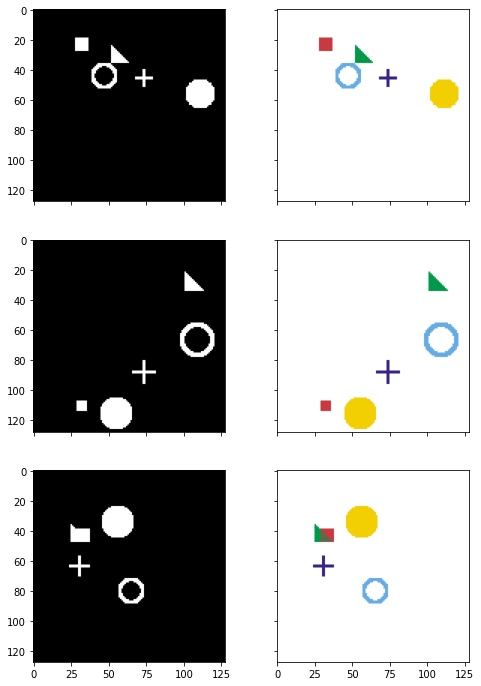

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np
import utils
import datasets.simulation as simulation

# Generate some random images
input_images, target_masks = simulation.generate_random_data(128, 128, size=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
utils.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [2]:
from datasets.simulation import SimDataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

torch.Size([25, 3, 128, 128]) torch.Size([25, 5, 128, 128])
0.0 1.0 0.04294922 0.20274267
0.0 1.0 0.008685059 0.09278812


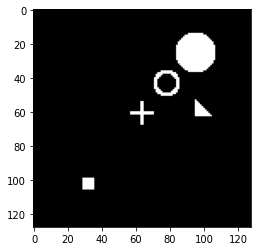

In [3]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

In [4]:
import torch
from torchsummary import summary
from models.unet import UNet

model = UNet(n_class=5)

In [5]:
from collections import defaultdict
import torch.nn.functional as F
from losses import dice_loss
from tqdm import tqdm

def calc_loss(logits, targets, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(logits, targets)
    dice = dice_loss(logits, targets)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * targets.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * targets.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * targets.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                scheduler.step()
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_class = 5

model = model.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
LR 0.001


/home/sm/.virtualenvs/seg/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train: bce: 0.098696, dice: 0.933043, loss: 0.515870
val: bce: 0.033335, dice: 0.799029, loss: 0.416182
saving best model
0m 11s
Epoch 1/24
----------
LR 0.001
train: bce: 0.028201, dice: 0.598017, loss: 0.313109
val: bce: 0.009834, dice: 0.307204, loss: 0.158519
saving best model
0m 11s
Epoch 2/24
----------
LR 0.001
train: bce: 0.008424, dice: 0.274983, loss: 0.141704
val: bce: 0.004217, dice: 0.242232, loss: 0.123224
saving best model
0m 11s
Epoch 3/24
----------
LR 0.001
train: bce: 0.003847, dice: 0.236271, loss: 0.120059
val: bce: 0.003137, dice: 0.232327, loss: 0.117732
saving best model
0m 11s
Epoch 4/24
----------
LR 0.001
train: bce: 0.002657, dice: 0.226660, loss: 0.114659
val: bce: 0.002147, dice: 0.225909, loss: 0.114028
saving best model
0m 11s
Epoch 5/24
----------
LR 0.001
train: bce: 0.002216, dice: 0.224393, loss: 0.113304
val: bce: 0.002028, dice: 0.225695, loss: 0.113862
saving best model
0m 11s
Epoch 6/24
----------
LR 0.001
train: bce: 0.001844, dice: 0.221002, lo

(3, 5, 128, 128)


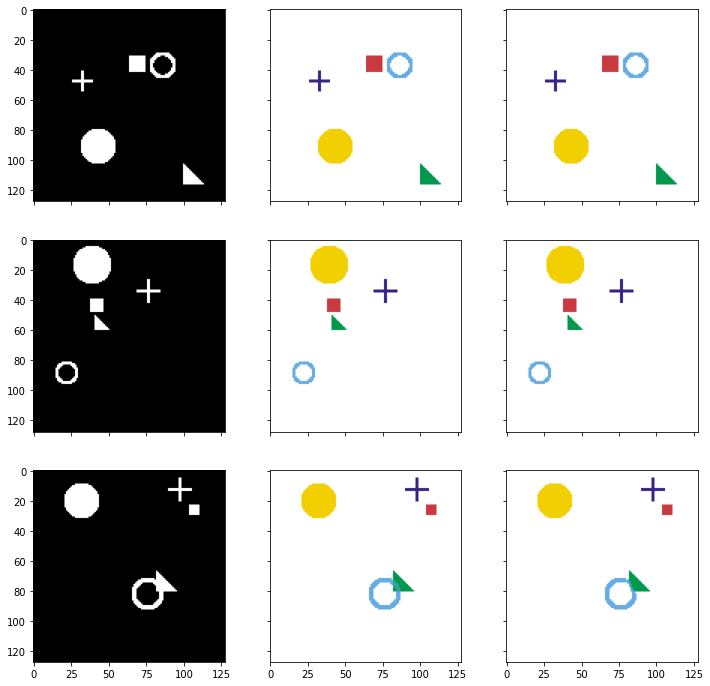

In [7]:
# prediction

import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [utils.masks_to_colorimg(x) for x in pred]

utils.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])